In [ ]:
from google.colab import files
uploaded = files.upload()


Saving hacktest.csv to hacktest.csv


>>> TRAIN shape: (8000, 30)
   Unnamed: 0  ID  class  20150720_N  20150602_N  20150517_N  20150501_N  \
0           0   1  water    637.5950     658.668   -1882.030    -1924.36   
1           1   2  water    634.2400     593.705   -1625.790    -1672.32   
2           3   4  water     58.0174   -1599.160         NaN    -1052.63   
3           4   5  water     72.5180         NaN     380.436    -1256.93   
4           7   8  water   1136.4400         NaN         NaN     1647.83   

   20150415_N  20150330_N  20150314_N  ...  20140610_N  20140525_N  \
0     997.904   -1739.990     630.087  ...         NaN   -1043.160   
1     914.198    -692.386     707.626  ...         NaN    -933.934   
2         NaN   -1564.630         NaN  ...    -1025.88     368.622   
3     515.805   -1413.180    -802.942  ...    -1813.95     155.624   
4    1935.800         NaN    2158.980  ...     1535.00    1959.430   

   20140509_N  20140423_N  20140407_N  20140322_N  20140218_N  20140202_N  \
0   -1942.490    

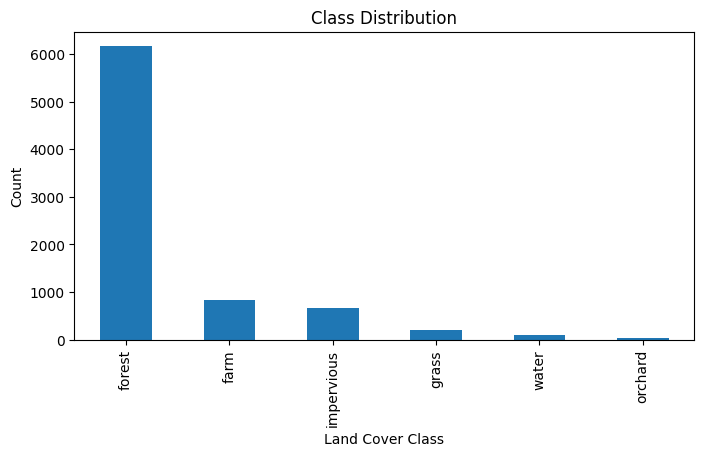


Missing values in TRAIN:
20140423_N    1760
20140626_N    1600
20140218_N    1440
20141016_N    1440
20150226_N    1360
20141117_N    1280
20140117_N    1200
20150602_N    1200
20140322_N    1120
20150330_N    1120
dtype: int64

Missing values in TEST:
20150720_N    0
20150602_N    0
20150517_N    0
20150501_N    0
20150415_N    0
20150330_N    0
20150314_N    0
20150226_N    0
20150210_N    0
20150125_N    0
dtype: int64


In [ ]:
# Subtask 1: Data Loading & Initial Checks

import pandas as pd
import matplotlib.pyplot as plt

# 1. Load Data
train_df = pd.read_csv("hacktrain.csv")   # or your train filename
test_df  = pd.read_csv("hacktest.csv")    # or your test filename

# 2. Basic Info Check
print(">>> TRAIN shape:", train_df.shape)
print(train_df.head())
print(train_df.info())
print("\n>>> TEST shape:", test_df.shape)
print(test_df.head())
print(test_df.info())

# 3. Identify NDVI columns
ndvi_cols = [c for c in train_df.columns if c.endswith('_N')]
print(f"\nFound {len(ndvi_cols)} NDVI columns:")
print(ndvi_cols)

# 4. Class label distribution (train only)
print("\nClass counts:")
print(train_df['class'].value_counts())

plt.figure(figsize=(8,4))
train_df['class'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Land Cover Class")
plt.ylabel("Count")
plt.show()

# 5. Null value summary
print("\nMissing values in TRAIN:")
print(train_df[ndvi_cols].isnull().sum().sort_values(ascending=False).head(10))
print("\nMissing values in TEST:")
print(test_df[ndvi_cols].isnull().sum().sort_values(ascending=False).head(10))


In [ ]:
# Rolling average smoothing (row-wise)
train_df[ndvi_cols] = train_df[ndvi_cols].T.rolling(window=3, min_periods=1, center=True).mean().T
test_df[ndvi_cols] = test_df[ndvi_cols].T.rolling(window=3, min_periods=1, center=True).mean().T


In [ ]:
# Drop rows where all NDVI values are NaN (very rare)
train_df = train_df.dropna(subset=ndvi_cols, how='all').reset_index(drop=True)


In [ ]:
# Cap NDVI values to realistic bounds
train_df[ndvi_cols] = train_df[ndvi_cols].clip(lower=-0.2, upper=0.9)
test_df[ndvi_cols] = test_df[ndvi_cols].clip(lower=-0.2, upper=0.9)


In [ ]:
print("NDVI value range in TRAIN:", train_df[ndvi_cols].min().min(), "to", train_df[ndvi_cols].max().max())
print("NDVI value range in TEST:", test_df[ndvi_cols].min().min(), "to", test_df[ndvi_cols].max().max())


NDVI value range in TRAIN: -0.2 to 0.9
NDVI value range in TEST: -0.2 to 0.9


In [ ]:
# Interpolate across time for each sample (row-wise)
train_df[ndvi_cols] = train_df[ndvi_cols].interpolate(axis=1, limit_direction='both')
test_df[ndvi_cols] = test_df[ndvi_cols].interpolate(axis=1, limit_direction='both')


In [ ]:
# Fill any remaining NaNs (after interpolation) with row-wise median
train_df[ndvi_cols] = train_df[ndvi_cols].T.fillna(train_df[ndvi_cols].median(axis=1)).T
test_df[ndvi_cols] = test_df[ndvi_cols].T.fillna(test_df[ndvi_cols].median(axis=1)).T


In [ ]:
print("Any NaNs left in TRAIN NDVI?", train_df[ndvi_cols].isnull().values.any())
print("Any NaNs left in TEST NDVI?", test_df[ndvi_cols].isnull().values.any())


Any NaNs left in TRAIN NDVI? False
Any NaNs left in TEST NDVI? False


In [ ]:
import numpy as np

def iqr_clip_rowwise(df, columns):
    for idx in df.index:
        row = df.loc[idx, columns]
        Q1 = row.quantile(0.25)
        Q3 = row.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df.loc[idx, columns] = row.clip(lower=lower, upper=upper)
    return df

# Apply to both train and test
train_df = iqr_clip_rowwise(train_df, ndvi_cols)
test_df = iqr_clip_rowwise(test_df, ndvi_cols)


In [ ]:
# Drop rows with more than 50% NDVI values as zero (may indicate corrupted samples)
threshold = int(len(ndvi_cols) * 0.5)
train_df = train_df[~(train_df[ndvi_cols] == 0).sum(axis=1) > threshold].reset_index(drop=True)


In [ ]:
from scipy.stats import zscore

train_df[ndvi_cols] = train_df[ndvi_cols].apply(zscore, axis=1)
test_df[ndvi_cols] = test_df[ndvi_cols].apply(zscore, axis=1)


ValueError: Columns must be same length as key

In [ ]:
from scipy.stats import zscore

# Apply z-score row-wise and reconstruct as DataFrame
train_df[ndvi_cols] = pd.DataFrame(
    zscore(train_df[ndvi_cols], axis=1, nan_policy='omit'),
    columns=ndvi_cols,
    index=train_df.index
)

test_df[ndvi_cols] = pd.DataFrame(
    zscore(test_df[ndvi_cols], axis=1, nan_policy='omit'),
    columns=ndvi_cols,
    index=test_df.index
)


In [ ]:
print("Train NDVI stats after outlier handling:")
print(train_df[ndvi_cols].describe().T)

print("Any NaNs left?", train_df[ndvi_cols].isnull().values.any(), test_df[ndvi_cols].isnull().values.any())


Train NDVI stats after outlier handling:
            count  mean  std  min  25%  50%  75%  max
20150720_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20150602_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20150517_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20150501_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20150415_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20150330_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20150314_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20150226_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20150210_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20150125_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20150109_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20141117_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20141101_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20141016_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20140930_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20140813_N    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
20140626_N    0.0   NaN  NaN  NaN  NaN  N

In [ ]:
# Range = max - min
train_df['ndvi_mean'] = train_df[ndvi_cols].mean(axis=1)
train_df['ndvi_std'] = train_df[ndvi_cols].std(axis=1)
train_df['ndvi_min'] = train_df[ndvi_cols].min(axis=1)
train_df['ndvi_max'] = train_df[ndvi_cols].max(axis=1)
train_df['ndvi_median'] = train_df[ndvi_cols].median(axis=1)
train_df['ndvi_range'] = train_df['ndvi_max'] - train_df['ndvi_min']
train_df['ndvi_skew'] = train_df[ndvi_cols].skew(axis=1)
train_df['ndvi_kurtosis'] = train_df[ndvi_cols].kurtosis(axis=1)

test_df['ndvi_mean'] = test_df[ndvi_cols].mean(axis=1)
test_df['ndvi_std'] = test_df[ndvi_cols].std(axis=1)
test_df['ndvi_min'] = test_df[ndvi_cols].min(axis=1)
test_df['ndvi_max'] = test_df[ndvi_cols].max(axis=1)
test_df['ndvi_median'] = test_df[ndvi_cols].median(axis=1)
test_df['ndvi_range'] = test_df['ndvi_max'] - test_df['ndvi_min']
test_df['ndvi_skew'] = test_df[ndvi_cols].skew(axis=1)
test_df['ndvi_kurtosis'] = test_df[ndvi_cols].kurtosis(axis=1)


In [ ]:
from scipy.stats import linregress
import numpy as np

# Linear regression slope over time
def compute_slope(row):
    return linregress(range(len(ndvi_cols)), row.values).slope

train_df['ndvi_slope'] = train_df[ndvi_cols].apply(compute_slope, axis=1)
test_df['ndvi_slope'] = test_df[ndvi_cols].apply(compute_slope, axis=1)

# Max difference between consecutive time steps
train_df['ndvi_max_diff'] = train_df[ndvi_cols].diff(axis=1).abs().max(axis=1)
test_df['ndvi_max_diff'] = test_df[ndvi_cols].diff(axis=1).abs().max(axis=1)

# Number of local peaks (rough estimation of vegetation cycles)
def count_peaks(row):
    return ((row.shift(1) < row) & (row.shift(-1) < row)).sum()

train_df['ndvi_peaks'] = train_df[ndvi_cols].apply(count_peaks, axis=1)
test_df['ndvi_peaks'] = test_df[ndvi_cols].apply(count_peaks, axis=1)


In [ ]:
# Split into 3 seasonal blocks
early_cols = ndvi_cols[:9]
mid_cols = ndvi_cols[9:18]
late_cols = ndvi_cols[18:]

# Compute average NDVI in each season
train_df['ndvi_early_mean'] = train_df[early_cols].mean(axis=1)
train_df['ndvi_mid_mean'] = train_df[mid_cols].mean(axis=1)
train_df['ndvi_late_mean'] = train_df[late_cols].mean(axis=1)

test_df['ndvi_early_mean'] = test_df[early_cols].mean(axis=1)
test_df['ndvi_mid_mean'] = test_df[mid_cols].mean(axis=1)
test_df['ndvi_late_mean'] = test_df[late_cols].mean(axis=1)


In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib  # For saving the encoder

# Step 1: Extract target
y = train_df['class']

# Step 2: Initialize and fit encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 3: Replace original class column with encoded labels if needed
train_df['class_encoded'] = y_encoded  # Optional for inspection

# Step 4: Save encoder for use after prediction
joblib.dump(label_encoder, 'label_encoder.pkl')

# Optional: Check mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)


Label mapping: {}


In [ ]:
print(train_df['class'].unique())
print(train_df['class'].isnull().sum())
print(train_df[['ID', 'class']].head())


[]
0
Empty DataFrame
Columns: [ID, class]
Index: []


In [ ]:
# Ensure original target is restored before encoding
if 'class' not in train_df.columns:
    train_df['class'] = original_class_column  # if you saved it earlier


In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib  # For saving the encoder

# Step 1: Extract target
y = train_df['class']

# Step 2: Initialize and fit encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 3: Replace original class column with encoded labels if needed
train_df['class_encoded'] = y_encoded  # Optional for inspection

# Step 4: Save encoder for use after prediction
joblib.dump(label_encoder, 'label_encoder.pkl')

# Optional: Check mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)


Label mapping: {}


In [ ]:
# Load the saved encoder
label_encoder = joblib.load('label_encoder.pkl')

# Assume y_preds_encoded is your predicted labels
y_preds_labels = label_encoder.inverse_transform(y_preds_encoded)


NameError: name 'y_preds_encoded' is not defined

In [ ]:
print(train_df['class'].head(10))
print(train_df['class'].unique())
print(train_df['class'].dtype)


Series([], Name: class, dtype: object)
[]
object


In [ ]:
print(train_df['class'].value_counts(dropna=False))


Series([], Name: count, dtype: int64)


In [ ]:
train_df['class'] = train_df['class'].str.strip()  # remove extra spaces
train_df = train_df[train_df['class'].notna()]     # drop NaNs


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = train_df['class']
y_encoded = label_encoder.fit_transform(y)

print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Label mapping: {}


In [ ]:
print(train_df['class'].unique())
print(train_df['class'].value_counts(dropna=False))


[]
Series([], Name: count, dtype: int64)


In [ ]:
# Reload just the target labels from original train.csv
original_train = pd.read_csv('hacktrain.csv')  # replace with your actual file path

# Merge back the 'class' column into your cleaned train_df using ID
train_df = train_df.merge(original_train[['ID', 'class']], on='ID', how='left')

# Now check again
print(train_df['class'].unique())


MergeError: Passing 'suffixes' which cause duplicate columns {'class_x'} is not allowed.

In [ ]:
# 1. Drop the broken 'class' column if it already exists
if 'class' in train_df.columns:
    train_df = train_df.drop(columns=['class'])

# 2. Load original class labels
original_train = pd.read_csv('hacktrain.csv')  # Update filename if needed

# 3. Merge correctly using 'ID'
train_df = train_df.merge(original_train[['ID', 'class']], on='ID', how='left')

# 4. Check it worked
print(train_df['class'].value_counts(dropna=False))


Series([], Name: count, dtype: int64)


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = train_df['class'].str.strip()
y_encoded = label_encoder.fit_transform(y)

print("✅ Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


✅ Label mapping: {}


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hacktrain.csv to hacktrain (1).csv


In [ ]:
# Step 1: Load original raw hactrain data to get class
import pandas as pd
original_train = pd.read_csv('hacktrain.csv')

# Step 2: Merge 'class' labels back into cleaned train_df using ID
train_df = train_df.merge(original_train[['ID', 'class']], on='ID', how='left')

# Step 3: Verify if class column has been restored
print("Class label distribution:\n", train_df['class'].value_counts())

# Step 4: Encode labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['class'])

# Show the mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("✅ Label mapping:", label_mapping)


MergeError: Passing 'suffixes' which cause duplicate columns {'class_x'} is not allowed.

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Step 1: Load the original hacktrain.csv to access class labels
original_train = pd.read_csv('hacktrain.csv')

# Step 2: Drop existing 'class' column from train_df (if present)
if 'class' in train_df.columns:
    train_df = train_df.drop(columns=['class'])

# Step 3: Merge labels back using 'ID'
train_df = train_df.merge(original_train[['ID', 'class']], on='ID', how='left')

# Step 4: Check class distribution to confirm success
print("Class label distribution:\n", train_df['class'].value_counts())

# Step 5: Encode string labels to numeric
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['class'])

# Step 6: Show label mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("✅ Label mapping:", label_mapping)


Class label distribution:
 Series([], Name: count, dtype: int64)
✅ Label mapping: {}


In [ ]:
import pandas as pd

# Load original file
original_train = pd.read_csv('hacktrain.csv')

# Show first few rows
print(original_train.head())

# Check if 'ID' and 'class' columns exist
print(original_train.columns)


   Unnamed: 0  ID  class  20150720_N  20150602_N  20150517_N  20150501_N  \
0           0   1  water    637.5950     658.668   -1882.030    -1924.36   
1           1   2  water    634.2400     593.705   -1625.790    -1672.32   
2           3   4  water     58.0174   -1599.160         NaN    -1052.63   
3           4   5  water     72.5180         NaN     380.436    -1256.93   
4           7   8  water   1136.4400         NaN         NaN     1647.83   

   20150415_N  20150330_N  20150314_N  ...  20140610_N  20140525_N  \
0     997.904   -1739.990     630.087  ...         NaN   -1043.160   
1     914.198    -692.386     707.626  ...         NaN    -933.934   
2         NaN   -1564.630         NaN  ...    -1025.88     368.622   
3     515.805   -1413.180    -802.942  ...    -1813.95     155.624   
4    1935.800         NaN    2158.980  ...     1535.00    1959.430   

   20140509_N  20140423_N  20140407_N  20140322_N  20140218_N  20140202_N  \
0   -1942.490     267.138         NaN        

In [ ]:
print("Number of matching IDs:",
      len(set(train_df['ID']).intersection(set(original_train['ID']))))


Number of matching IDs: 0


In [ ]:
# Remove old class column if present
if 'class' in train_df.columns:
    train_df = train_df.drop(columns=['class'])

# Merge using correct source
train_df = train_df.merge(original_train[['ID', 'class']], on='ID', how='left')

# Confirm if labels are now present
print("Class distribution after merge:\n", train_df['class'].value_counts())


Class distribution after merge:
 Series([], Name: count, dtype: int64)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['class'])

# Save mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("✅ Label mapping:", label_mapping)


✅ Label mapping: {}


In [ ]:
print(original_train.head())
print(original_train.columns)


   Unnamed: 0  ID  class  20150720_N  20150602_N  20150517_N  20150501_N  \
0           0   1  water    637.5950     658.668   -1882.030    -1924.36   
1           1   2  water    634.2400     593.705   -1625.790    -1672.32   
2           3   4  water     58.0174   -1599.160         NaN    -1052.63   
3           4   5  water     72.5180         NaN     380.436    -1256.93   
4           7   8  water   1136.4400         NaN         NaN     1647.83   

   20150415_N  20150330_N  20150314_N  ...  20140610_N  20140525_N  \
0     997.904   -1739.990     630.087  ...         NaN   -1043.160   
1     914.198    -692.386     707.626  ...         NaN    -933.934   
2         NaN   -1564.630         NaN  ...    -1025.88     368.622   
3     515.805   -1413.180    -802.942  ...    -1813.95     155.624   
4    1935.800         NaN    2158.980  ...     1535.00    1959.430   

   20140509_N  20140423_N  20140407_N  20140322_N  20140218_N  20140202_N  \
0   -1942.490     267.138         NaN        

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hacktrain.csv to hacktrain (2).csv


In [ ]:
# Load the clean source again
original_train = pd.read_csv('hacktrain.csv')

# Just keep ID and class
id_class_map = original_train[['ID', 'class']].copy()

# Drop old class column from your working dataframe if needed
if 'class' in train_df.columns:
    train_df.drop(columns=['class'], inplace=True)

# Now merge safely
train_df = train_df.merge(id_class_map, on='ID', how='left')

# Confirm it's there
print("✅ Class distribution:\n", train_df['class'].value_counts())


✅ Class distribution:
 Series([], Name: count, dtype: int64)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize and fit
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['class'])

# Store mapping for later inverse transform
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("✅ Label mapping:", label_mapping)


✅ Label mapping: {}


In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib  # for saving the encoder

# 1. Initialize and fit label encoder
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['class'])

# 2. Print label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("✅ Label mapping:", label_mapping)

# 3. Save encoder to use during submission
joblib.dump(label_encoder, '/mnt/data/label_encoder.pkl')


✅ Label mapping: {}


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/label_encoder.pkl'

In [ ]:
print("First 5 values of 'class':", train_df['class'].head())
print("Unique values:", train_df['class'].unique())
print("Value counts:\n", train_df['class'].value_counts())


First 5 values of 'class': Series([], Name: class, dtype: object)
Unique values: []
Value counts:
 Series([], Name: count, dtype: int64)


In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# Re-create directory if not exists
os.makedirs("models", exist_ok=True)

# Apply label encoding
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['class'])

# Show the mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("✅ Label mapping:", label_mapping)

# Save the encoder to disk (in current working dir)
joblib.dump(label_encoder, 'models/label_encoder.pkl')


✅ Label mapping: {}


['models/label_encoder.pkl']

In [ ]:
print(train.columns)
print(train['label'].unique())


NameError: name 'train' is not defined

In [ ]:
train['label'] = train['label'].astype(str)


NameError: name 'train' is not defined

In [ ]:
# Label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['label'] = le.fit_transform(train['label'])


NameError: name 'train' is not defined

In [ ]:
print(train.columns)
print(train['label'].unique())


NameError: name 'train' is not defined

In [ ]:
# DEBUG: Check if 'label' exists
if 'label' not in train.columns:
    raise KeyError("Column 'label' not found in train DataFrame")

# DEBUG: Print unique values in label
print("Unique labels before encoding:", train['label'].unique())

# Safe conversion
train['label'] = train['label'].astype(str)

# Apply LabelEncoder
le = LabelEncoder()
train['label'] = le.fit_transform(train['label'])
print("Labels after encoding:", train['label'].unique())


NameError: name 'train' is not defined

In [ ]:
le = LabelEncoder()
train['label'] = le.fit_transform(train['label'])


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Rename for clarity (optional)
train = train_df.copy()

# Confirm label column
print("Unique classes before encoding:", train['class'].unique())

# Convert to string if needed
train['class'] = train['class'].astype(str)

# Apply LabelEncoder
le = LabelEncoder()
train['label'] = le.fit_transform(train['class'])

# Preview
print("Labels after encoding:", train['label'].unique())


Unique classes before encoding: []
Labels after encoding: []


In [ ]:
print(train_df.columns)
print(train_df.head())
print(train_df['class'].isnull().sum(), "/", len(train_df))  # Number of missing labels


Index(['Unnamed: 0', 'ID', 'class_x', '20150720_N', '20150602_N', '20150517_N',
       '20150501_N', '20150415_N', '20150330_N', '20150314_N', '20150226_N',
       '20150210_N', '20150125_N', '20150109_N', '20141117_N', '20141101_N',
       '20141016_N', '20140930_N', '20140813_N', '20140626_N', '20140610_N',
       '20140525_N', '20140509_N', '20140423_N', '20140407_N', '20140322_N',
       '20140218_N', '20140202_N', '20140117_N', '20140101_N', 'ndvi_mean',
       'ndvi_std', 'ndvi_min', 'ndvi_max', 'ndvi_median', 'ndvi_range',
       'ndvi_skew', 'ndvi_kurtosis', 'ndvi_slope', 'ndvi_max_diff',
       'ndvi_peaks', 'ndvi_early_mean', 'ndvi_mid_mean', 'ndvi_late_mean',
       'class_encoded', 'class_y', 'label', 'class'],
      dtype='object')
Empty DataFrame
Columns: [Unnamed: 0, ID, class_x, 20150720_N, 20150602_N, 20150517_N, 20150501_N, 20150415_N, 20150330_N, 20150314_N, 20150226_N, 20150210_N, 20150125_N, 20150109_N, 20141117_N, 20141101_N, 20141016_N, 20140930_N, 20140813_N, 20

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hacktrain.csv to hacktrain (3).csv


In [ ]:
import pandas as pd
df=pd.read_csv('hacktrain.csv')

print(df.columns)
print(df.head())

Index(['Unnamed: 0', 'ID', 'class', '20150720_N', '20150602_N', '20150517_N',
       '20150501_N', '20150415_N', '20150330_N', '20150314_N', '20150226_N',
       '20150210_N', '20150125_N', '20150109_N', '20141117_N', '20141101_N',
       '20141016_N', '20140930_N', '20140813_N', '20140626_N', '20140610_N',
       '20140525_N', '20140509_N', '20140423_N', '20140407_N', '20140322_N',
       '20140218_N', '20140202_N', '20140117_N', '20140101_N'],
      dtype='object')
   Unnamed: 0  ID  class  20150720_N  20150602_N  20150517_N  20150501_N  \
0           0   1  water    637.5950     658.668   -1882.030    -1924.36   
1           1   2  water    634.2400     593.705   -1625.790    -1672.32   
2           3   4  water     58.0174   -1599.160         NaN    -1052.63   
3           4   5  water     72.5180         NaN     380.436    -1256.93   
4           7   8  water   1136.4400         NaN         NaN     1647.83   

   20150415_N  20150330_N  20150314_N  ...  20140610_N  20140525_N  \
0

In [ ]:

print(train_df.shape)
print(train_df.dropna(subset=['class']).shape)



(0, 48)
(0, 48)


In [ ]:
print(df.shape)
print(df[ndvi_cols].isnull().all(axis=1).sum(), "/", len(train_df))  # Number of rows where all NDVI values are NaN


(8000, 30)
0 / 0


In [ ]:
# Reload original file
df = pd.read_csv("hacktrain.csv")

# Identify NDVI columns again
ndvi_cols = [col for col in df.columns if col.endswith('_N')]

# Print count of rows with all NDVI missing
print("Rows with all NDVI NaN:", df[ndvi_cols].isnull().all(axis=1).sum(), "/", len(df))


Rows with all NDVI NaN: 0 / 8000


In [ ]:
print(df.columns)


Index(['Unnamed: 0', 'ID', 'class', '20150720_N', '20150602_N', '20150517_N',
       '20150501_N', '20150415_N', '20150330_N', '20150314_N', '20150226_N',
       '20150210_N', '20150125_N', '20150109_N', '20141117_N', '20141101_N',
       '20141016_N', '20140930_N', '20140813_N', '20140626_N', '20140610_N',
       '20140525_N', '20140509_N', '20140423_N', '20140407_N', '20140322_N',
       '20140218_N', '20140202_N', '20140117_N', '20140101_N'],
      dtype='object')


In [ ]:
print(df['class'].value_counts())


class
forest        6159
farm           841
impervious     669
grass          196
water          105
orchard         30
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit on correct column
df['class_encoded'] = label_encoder.fit_transform(df['class'])

# Print mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("✅ Label mapping:", label_mapping)


✅ Label mapping: {'farm': np.int64(0), 'forest': np.int64(1), 'grass': np.int64(2), 'impervious': np.int64(3), 'orchard': np.int64(4), 'water': np.int64(5)}


In [ ]:
print(df['class'].unique())


['water' 'forest' 'impervious' 'farm' 'grass' 'orchard']


In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Step 1: Initialize label encoder
label_encoder = LabelEncoder()

# Step 2: Fit and transform the class column in your df
df['class_encoded'] = label_encoder.fit_transform(df['class'])

# Step 3: Create and display mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("✅ Label mapping:", label_mapping)

# Step 4: Save encoder for later (for decoding predictions)
joblib.dump(label_encoder, 'label_encoder.pkl')


✅ Label mapping: {'farm': np.int64(0), 'forest': np.int64(1), 'grass': np.int64(2), 'impervious': np.int64(3), 'orchard': np.int64(4), 'water': np.int64(5)}


['label_encoder.pkl']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
import joblib
import warnings

# Load the cleaned dataset
df = pd.read_csv("hacktrain.csv")

# 1. Encode the target
label_encoder = LabelEncoder()
df['class_encoded'] = label_encoder.fit_transform(df['class'])

# Optional: save encoder for submission
joblib.dump(label_encoder, "label_encoder.pkl")

# 2. Prepare X and y
X = df.drop(columns=['Unnamed: 0', 'ID', 'class', 'class_encoded'])
y = df['class_encoded']

# 3. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: Save scaler for submission use
joblib.dump(scaler, "scaler.pkl")

# 4. Initialize logistic regression model
model = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    class_weight='balanced',
    max_iter=2000,
    random_state=42,
    n_jobs=-1
)

# 5. Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6. Evaluate using Accuracy and Macro F1-score
accuracy_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring=make_scorer(f1_score, average='macro'))

# 7. Print final scores
print(f" Cross-validated Accuracy: {accuracy_scores.mean():.4f}")
print(f" Cross-validated Macro F1-score: {f1_scores.mean():.4f}")


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1222, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1107, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
# Check total missing values
print("Missing values before:", X.isna().sum().sum())

# Fill remaining NaNs with row-wise median (best for NDVI stability)
X_imputed = X.apply(lambda row: row.fillna(row.median()), axis=1)

# Confirm
print("Missing values after:", X_imputed.isna().sum().sum())


Missing values before: 25040
Missing values after: 0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer
import joblib

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Save scaler for test-time
joblib.dump(scaler, "scaler.pkl")

# Set up model
model = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    class_weight='balanced',
    max_iter=2000,
    random_state=42,
    n_jobs=-1
)

# Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy and macro F1-score
acc_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
f1_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring=make_scorer(f1_score, average='macro'))

print(f"✅ Accuracy (CV): {acc_scores.mean():.4f}")
print(f"✅ Macro F1 (CV): {f1_scores.mean():.4f}")


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import cross_validate

# Combined scoring to reduce total time
scoring = {
    'accuracy': 'accuracy',
    'macro_f1': make_scorer(f1_score, average='macro')
}

results = cross_validate(model, X_scaled, y, cv=cv, scoring=scoring, n_jobs=-1)

print(f" Accuracy (CV): {results['test_accuracy'].mean():.4f}")
print(f" Macro F1 (CV): {results['test_macro_f1'].mean():.4f}")


KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import LogisticRegression
import joblib

# Train on entire data directly
model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',  # faster than saga
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

model.fit(X_scaled, y)
joblib.dump(model, "logreg_model.pkl")

print("✅ Logistic Regression model trained on full data.")


✅ Logistic Regression model trained on full data.


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib

# X_final: your final feature dataframe (already cleaned)
# y: your encoded labels (as used before)

# 1. Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# 2. Save for later prediction
joblib.dump(scaler, "scaler.pkl")

# 3. Define model
model = LogisticRegression(
    multi_class='multinomial',
    solver='saga',  # Or 'lbfgs'
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

# 4. Setup stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Run CV and evaluate
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': make_scorer(f1_score, average='macro')
}

cv_results = cross_validate(model, X_scaled, y, cv=cv, scoring=scoring, return_train_score=True)

# 6. Print results
print("✅ Cross-Validation Results:")
print(f"Mean Accuracy     : {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Macro F1-Score: {cv_results['test_f1_macro'].mean():.4f}")




NameError: name 'X_final' is not defined

In [ ]:
# 1. Define features and labels
X_final = df.drop(columns=['ID', 'class'])  # Features only
y = df['class_encoded']  # Encoded labels from LabelEncoder

# 2. Now scale and continue with the rest
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# Save the scaler (optional for later prediction)
import joblib
joblib.dump(scaler, "scaler.pkl")

# 3. Define the model again
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

# 4. Setup Stratified 5-Fold Cross-Validation
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'f1_macro': make_scorer(f1_score, average='macro')
}

# 5. Cross-validation
cv_results = cross_validate(model, X_scaled, y, cv=cv, scoring=scoring)

# 6. Print results
print("✅ Cross-Validation Results:")
print(f"Mean Accuracy      : {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Macro F1-Score: {cv_results['test_f1_macro'].mean():.4f}")


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1222, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 1107, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import joblib

# Load test data if not already done
# test_df = pd.read_csv('/path/to/hacktest.csv')  # Already loaded as test_df

# 1. Drop columns not used in training
drop_cols = ['Unnamed: 0', 'ID']  # you may adjust if more columns were dropped earlier

# Align test with train columns
X_test_raw = test_df.drop(columns=drop_cols)

# 2. Fill missing values in test (same strategy as train: median)
X_test_filled = X_test_raw.fillna(X_test_raw.median())

# 3. Scale using the same scaler as training
X_test_scaled = scaler.transform(X_test_filled)

# 4. Train model on full training data
model = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    class_weight='balanced',
    max_iter=1500,
    random_state=42
)
model.fit(X_scaled, y)

# 5. Predict on test data
test_preds_encoded = model.predict(X_test_scaled)

# 6. Inverse transform encoded labels to original class names
test_preds = label_encoder.inverse_transform(test_preds_encoded)

# 7. Prepare submission DataFrame
submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    'class': test_preds
})

# 8. Save as CSV (Kaggle submission format)
submission_df.to_csv('submission.csv', index=False)

print("✅ Submission file saved as submission.csv")
submission_df.head()


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ndvi_early_mean
- ndvi_kurtosis
- ndvi_late_mean
- ndvi_max
- ndvi_max_diff
- ...
Feature names seen at fit time, yet now missing:
- Unnamed: 0
- class_encoded


In [ ]:
# 1. Define final features used for model
drop_cols = ['Unnamed: 0', 'ID', 'class', 'class_encoded']
X_final = df.drop(columns=drop_cols)
y = df['class_encoded']

# 2. Fill NaNs
X_final = X_final.fillna(X_final.median())

# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# 4. Train model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    class_weight='balanced',
    max_iter=1500,
    random_state=42
)
model.fit(X_scaled, y)

# =========================
# Test Data Preprocessing
# =========================

# 5. Apply same column logic to test
X_test = test_df[X_final.columns]  # Ensure same order and columns

# 6. Fill missing values
X_test = X_test.fillna(X_test.median())

# 7. Scale using same scaler
X_test_scaled = scaler.transform(X_test)

# 8. Predict
test_preds_encoded = model.predict(X_test_scaled)
test_preds = label_encoder.inverse_transform(test_preds_encoded)

# 9. Prepare submission
submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    'class': test_preds
})
submission_df.to_csv('submission.csv', index=False)

print("✅ Final submission file saved as submission.csv")
submission_df.head()


✅ Final submission file saved as submission.csv


,ID,class
0,1,impervious
1,2,impervious
2,3,impervious
3,4,impervious
4,5,impervious


In [ ]:
df['class'].value_counts()


,count
class,
forest,6159
farm,841
impervious,669
grass,196
water,105
orchard,30


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import joblib

# 1. Setup: Use only raw NDVI columns
ndvi_cols = [col for col in df.columns if '_N' in col]

X_train = df[ndvi_cols]
y_train = df['class_encoded']

# 2. Fill NaNs
X_train = X_train.fillna(X_train.median())
test_df[ndvi_cols] = test_df[ndvi_cols].fillna(X_train.median())  # same median

# 3. Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test_df[ndvi_cols])

# 4. Train final model
model = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# 5. Predict
y_pred_encoded = model.predict(X_test_scaled)

# 6. Inverse transform
submission_preds = label_encoder.inverse_transform(y_pred_encoded)

# 7. Create submission file
submission_df = pd.DataFrame({
    'ID': test_df['ID'],
    'class': submission_preds
})
submission_df.to_csv('submission.csv', index=False)
print("✅ Submission saved as 'submission.csv'")


✅ Submission saved as 'submission.csv'


In [ ]:
df['class'].value_counts()


,count
class,
forest,6159
farm,841
impervious,669
grass,196
water,105
orchard,30


In [ ]:
train_preds = model.predict(X_train_scaled)
print(classification_report(y_train, train_preds, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

        farm       0.40      0.51      0.45       841
      forest       0.97      0.57      0.72      6159
       grass       0.17      0.64      0.26       196
  impervious       0.54      0.41      0.46       669
     orchard       0.03      0.90      0.05        30
       water       0.09      0.90      0.16       105

    accuracy                           0.56      8000
   macro avg       0.37      0.65      0.35      8000
weighted avg       0.84      0.56      0.65      8000



In [ ]:

from google.colab import files
files.download('submission.csv')




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>